In [14]:
import requests
import json
import time
from datetime import date
from datetime import datetime
from helpers.history_fetcher import HistoryFetcher
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdelt # pip install gdelt
import folium
import os
from tqdm import tqdm_notebook # conda install tqdm
import operator
from helpers.wiki_helpers import wiki_change_factor, make_folium_map

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### Introduction

Our project idea came from the observation that some wikipedia pages seems to get updated a lot after a related events happens. This could be observed during the Catalonia crisis that happened in september-october 2017. 

TODO must explain differences between initial plan and this plan.

Part 1

The first step for our project was then to find evidence of the correlation between events and edits on wikipedia. To tackle this problem we decided to first take a special case: the 2014 Ukraine war. Our approach is to first show a visual argument (plots).

---
### Part I - Finding evidence of (main events => lots of wikipedia edits)

#### 1 - Find a dataset that contains events for the Ukraine war. 

The UCDP GED dataset is perfectly suited for this task as it contains all armed events that happen in Ukraine in 2014. 

In [3]:
gd1 = gdelt.gdelt(version=1)
results = gd1.Search(['2014 February 01','2014 April 30'],table='events')

/Users/combes/anaconda3/lib/python3.6/site-packages/gdelt/parallel.py:69: UserWarning: GDELT does not have a url for date time 20140319
  warnings.warn(message)
/Users/combes/anaconda3/lib/python3.6/site-packages/gdelt/parallel.py:105: UserWarning: GDELT did not return data for date time 20140319
  warnings.warn(message)


In [15]:
results.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'CAMEOCodeDescription', 'EventBaseCode', 'EventRootCode',
       'QuadClass', 'GoldsteinScale', 'NumMentions', 'NumSources',
       'NumArticles', 'AvgTone', 'Actor1Geo_Type', 'Actor1Geo_FullName',
       'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code',
       'Actor2Geo_Lat', 'Actor2Geo_Long', 'Actor

In [5]:
ukraine_events = results[results['ActionGeo_CountryCode'] == 'UP']
ukraine_events['SQLDATE'] = ukraine_events['SQLDATE'].map(lambda d: pd.Timestamp(str(d)))
ukraine_events = ukraine_events.set_index('SQLDATE')
ukraine_events = ukraine_events.loc[ukraine_events.index > pd.Timestamp('20140101')]
ukraine_events_dates = list(ukraine_events.index)

#### 2 - Grab the history (i.e. edits) of Ukraine's wikipedia page.

In order to grab the edits history for any wikipedia page, we used wikipedia's API and abtracted it through our HistoryFetcher class. 

In [6]:
history_fetcher = HistoryFetcher('Ukraine')
response = history_fetcher.get_history('20140101000000', '20140601000000')

In [7]:
dates = list(map(lambda revision: revision['timestamp'], response))
changes_size = list(map(lambda revision: revision['change_size'], response))

#### 3 - Plot the number of edits and events over time

This task was done using simple plots with matplotlib

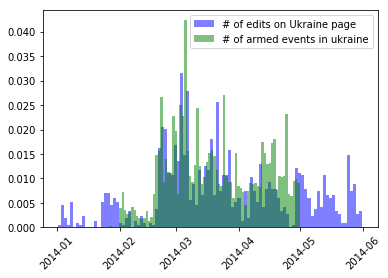

In [14]:
plt.hist(dates, bins=100, normed=True, color='blue', alpha=0.5, label='# of edits on Ukraine page')
#plt.hist(ukraine_war_dates, bins=100, alpha=0.5, color='grey', label='# of edits on Ukraine war page')
plt.hist(ukraine_events_dates, bins=100, color='green', normed=True, alpha=0.5, label='# of armed events in ukraine')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

### Comments, conlusions
By combining 2 datasets we can see, that wikipedia changes for Ukraine are related to the armed events.


TODO part on events that are not detected : example 2015 terror attacks in Paris

---
### Part II - A first prototype for our countries index - Analysing Dynamism of Wikipedia Changes

We designed a simple classifier to show how many time wikipedia content varies a lot in time. Our classifieris based on the mean of the wikipedia changes. If for some month there are number of changes that vary from the mean value too much, we mark this event as "out of norm" and at the end we sum these events and divide by the whole number of changes for the period.

/Users/patryk/GoogleDrive/studies/ADA/work/ada-2017/project/helpers/wiki_helpers.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


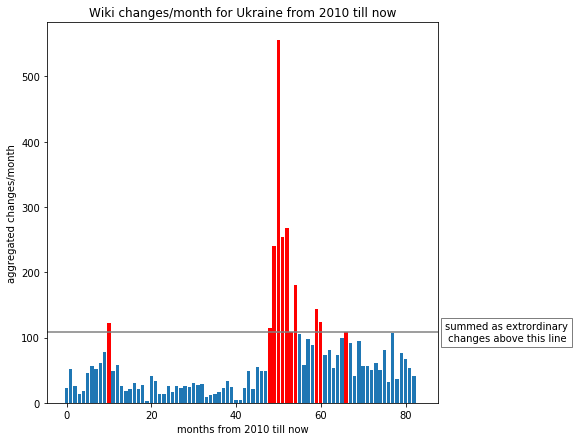

Wikipedia Instability for Ukraine : 0.415448068991


In [6]:
inst_uk = wiki_change_factor('Ukraine',2010, outlier_factor=1.7, plot_on=True)
print('Wikipedia Instability for Ukraine :',inst_uk)

/Users/patryk/GoogleDrive/studies/ADA/work/ada-2017/project/helpers/wiki_helpers.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


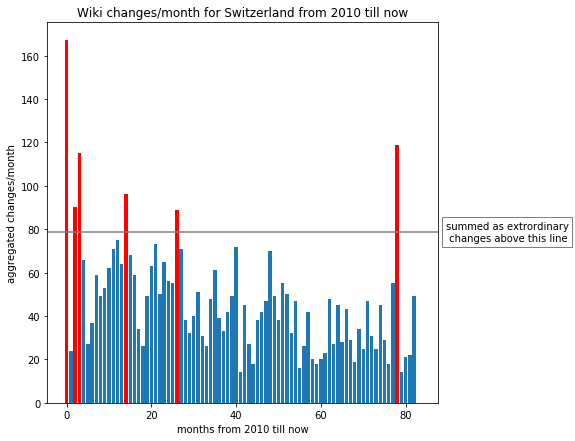

Wikipedia Instability for Switzerland : 0.174002574003


In [7]:
inst_ch = wiki_change_factor('Switzerland',2010, outlier_factor=1.7, plot_on=True)
print('Wikipedia Instability for Switzerland :',inst_ch)

By plotting these values for different countries in Europe , we could plot a Map with different Wikipedia dynamism rate 

A Jupyter Widget

/Users/patryk/GoogleDrive/studies/ADA/work/ada-2017/project/helpers/wiki_helpers.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


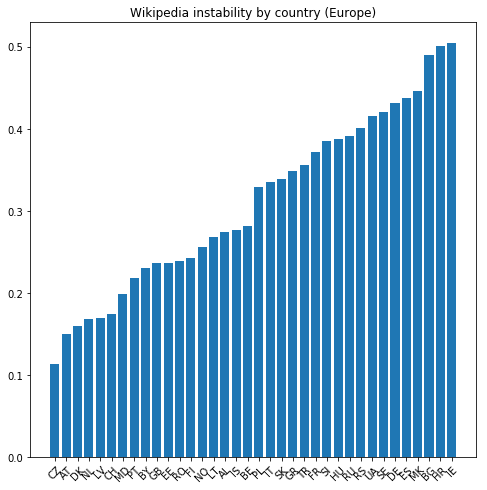

In [8]:
countries = ['Ukraine','Poland','Spain', 'Netherlands','France','Germany','Switzerland','Belgium',
            'Portugal','Italy','Great Britain', 'Ireland', 'Norway', 'Sweden','Denmark',
            'Slovakia','Czech Republic','Austria','Hungary','Croatia','Romania','Greece','Serbia',
            'Macedonia','Albania','Estonia','Latvia','Finland','Lithuania','Russia','Bulgaria','Moldova',
            'Belarus','Slovenia','Turkey','Iceland']
codes = ['UA','PL','ES', 'NL','FR','DE','CH','BE', 'PT','IT','GB','IE','NO','SE','DK',
        'SK','CZ','AT','HU','HR','RO','GR','RS','MK','AL','EE','LV','FI','LT','RU','BG','MD',
        'BY','SI','TR','IS']
wiki_change_values = {};
for i in tqdm_notebook(range(len(countries))):
    wiki_change_values[codes[i]] = wiki_change_factor(countries[i], 2010, outlier_factor = 1.7)

    
sorted_x = sorted(wiki_change_values.items(), key=lambda x: x[1])
values = np.zeros([len(sorted_x),1])
names = ['']*len(sorted_x)
for i in range(len(sorted_x)):
    names[i] = sorted_x[i][0]
    values[i] = sorted_x[i][1]
values= np.squeeze(values)

plt.rcParams["figure.figsize"] = (8,8)
plt.bar(range(len(sorted_x)), values, align='center')
plt.xticks(range(len(sorted_x)), names, rotation=45)
plt.title('Wikipedia instability by country (Europe)')
plt.show()

We could observe, that  as expected some very developed and stable countries have very stable wikipedia, and the less stable also less stable wikipedia. However we could observe some interesting facts for some nations:
- Ukraine has lots of instability due to war
- Germany or Croatia has a lot of instability in its wikipedia - to be discovered why
- The computed instability factor highly depends on the outliers threshold and computation method, therefore we shoudl validate if our method is valid.

### Wikipedia Instability Map in Europe.

In [15]:
colors_eu = ['#ffe5d0', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#89000d']
thresh_eu = [0.25      , 0.3      , 0.35      , 0.4     , 0.45     , 0.5     , 0.55     , 0.6]


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        val = wiki_change_values[state]
    except KeyError:
        return '#bdbdbd'
    
    if np.isnan(val):
        return '#bdbdbd'
    length = len(colors_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]


m = make_folium_map('data/europe2.topojson.json', 'objects.europe',
                    wiki_changes_colors_eu, 0.25, 0.65, colors_eu, 
                    [56,10], 3.5, '% Wiki page instability 2010-2017')

m

### Conclusions to Part II
1. We can see that usually smaller countries has more stable wikipedia --> less things are happening
2. We can observe that in Ukraine there were major changes, probably due to War
3. High changes in Germany or Croatia are bizzare, we'll examine this issue in our final report.

---
### Part III - Showing the limits

### Temp Garbage

In [ ]:
dates_events = ukraine_ged_df.date_start.values
deaths_all = ukraine_ged_df['deaths all'].values

ukraine_war_history_fetcher = HistoryFetcher('War in Donbass')
ukraine_war_response = history_fetcher.get_history('20140101000000', '20161130000000')

ukraine_war_dates = list(map(lambda revision: revision['timestamp'], ukraine_war_response))

In [256]:
spain_history_fetcher = HistoryFetcher('Catalonia')
spain_history = spain_history_fetcher.get_history('20170901000000', '20171115000000')
spain_dates = list(map(lambda revision: revision['timestamp'], spain_history))

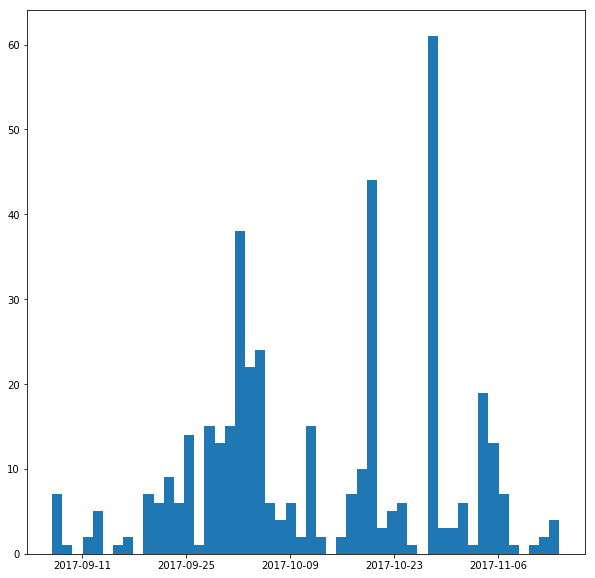

In [257]:
plt.hist(spain_dates, bins=50)
plt.show()

In [16]:
france_history_fetcher = HistoryFetcher('France')
france_history = france_history_fetcher.get_history('20141201000000', '20160230000000')
france_dates = list(map(lambda revision: revision['timestamp'], france_history))

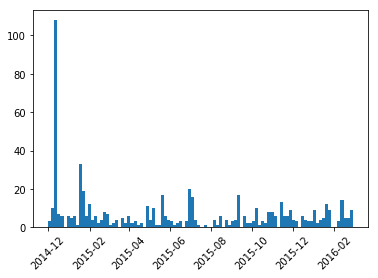

In [22]:
plt.hist(france_dates, bins=100)
plt.xticks(rotation=45)
plt.show()

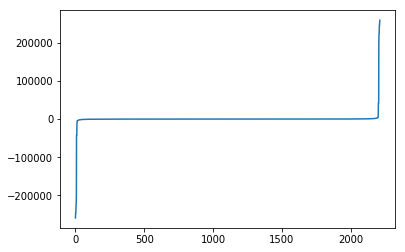

In [153]:
plt.plot(sorted(changes_size))
plt.show()

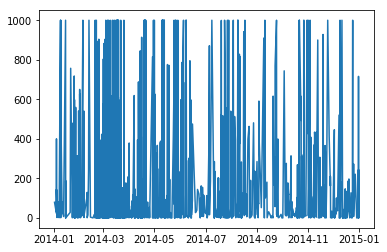

In [151]:
plt.plot(dates, list(map(lambda cs: max(min(abs(cs), 1000), -1000), changes_size)))
plt.show()

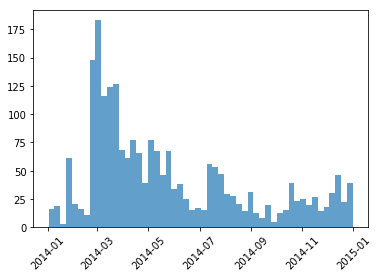

In [154]:
plt.hist(dates, bins=52, alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [135]:
catalonia_history_fetcher = HistoryFetcher('Catalonia')
catalonia_response = catalonia_history_fetcher.get_history('20170801000000', '20171120000000')
catalonia_dates = list(map(lambda revision: dateutil.parser.parse(revision['timestamp']), catalonia_response))